# Классификация летательных аппартатов.


Перед вами стоит задача написать свою сеточку без использования предобученных. Нашей целью будет научиться классифицировать летательные аппараты в небе, такие как самолет, джет, дрон, вертолет и ракета. 



 ![alt text](https://i.mycdn.me/i?r=AzF-kPXTZw6IaWs3aSUGrfjPqUvSFXbXZjS9ETU_SPXIDPRCu6D2qclJT0qwJlg-gZA)






Для того, чтобы сохранить вес модели, надо подключить drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Изображения импортируются.

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1pvsgHExIgPqpJeoW6vp8RziMfskLS5qW',
                                    dest_path='/content/data.zip',
                                    unzip=True)

In [ ]:
import numpy as np
import pandas as pd
import torch

import PIL

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import pickle
import numpy as np
from skimage import io
import random

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# мы будем игнорировать warnings, так как вы блокнотах в sklearn не все бывает гладко
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")

### Пример аугментаций

Самым важным преобразованием для увеличения данных является «RandomErasing»: случайным образом выбирает прямоугольную область на изображении и стирает ее пиксели. Это позволит избежать переобучения.

In [ ]:
class PlanesDataset(Dataset):
  def __init__(self, files, mode, augmentations = False):
    super().__init__()
    self.files = files
    self.mode = mode
    self.augmentations = augmentations

    if self.mode not in DATA_MODES:
      print(f'wrong mode: {self.mode}')
      raise NameError

    self.len_ = len(self.files)
    self.label_encoder = LabelEncoder()

    if self.mode != 'test':
      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open('label_encoder.pkl', 'wb') as le_dump:
        pickle.dump(self.label_encoder, le_dump)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    if self.augmentations==True:
      transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), interpolation=3),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=20,translate=(0.12,0.12),resample=PIL.Image.NEAREST,fillcolor=20),
        transforms.RandomPerspective(distortion_scale=0.25,),
        transforms.ColorJitter(brightness=0.3,contrast=0.3,saturation=1,hue=0.10),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.75, scale=(0.02, 0.2)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
      ])
    else:
        transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE), interpolation=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                
      ])

    x = self.load_sample(self.files[index])
    #x = self._prepare_sample(x)

    x=np.array(x)
    #x = np.array(x / 255, dtype='float32')

    x = transform(x)
  
    if self.mode == 'test':
      return x
    else:        
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y

  def _prepare_sample(self, image):
    image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(image)

In [ ]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split
from pathlib import PosixPath

# делим тренировочный сет на валидационный и тренировочный 30/70

train_val_labels = [path.parent.name for path in train_val_files]

'''
train_files, val_files = train_test_split(train_val_files, test_size=0.3, \
                                          stratify=train_val_labels)

f = open("/content/drive/My Drive/train_files.txt", "w")
f.write(str(train_files))
f.close()
g = open("/content/drive/My Drive/val_files.txt", "w")
g.write(str(val_files))
g.close() '''

'\ntrain_files, val_files = train_test_split(train_val_files, test_size=0.3,                                           stratify=train_val_labels)\n\nf = open("/content/drive/My Drive/train_files.txt", "w")\nf.write(str(train_files))\nf.close()\ng = open("/content/drive/My Drive/val_files.txt", "w")\ng.write(str(val_files))\ng.close() '

Разделение между обучающим набором и проверочным набором сохраняется. Это позволило мне переобучить модель с такими же данными.

In [ ]:
with open("/content/drive/My Drive/train_files.txt", "r") as f:
  train_files=eval(f.read())

with open("/content/drive/My Drive/val_files.txt", "r") as f:
  val_files=eval(f.read())

In [ ]:
val_dataset = PlanesDataset(val_files, mode='val',augmentations=False)
train_dataset = PlanesDataset(train_files, mode='train',augmentations=True)

# Изучаем данные

In [ ]:
def imshow(img, title=None, plt_ax=plt, default=False):
  img = img.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = std * img + mean
  img = np.clip(img, 0, 1)
  plt_ax.imshow(img)
  if title is not None:
    plt_ax.set_title(title)
  plt_ax.grid(False)

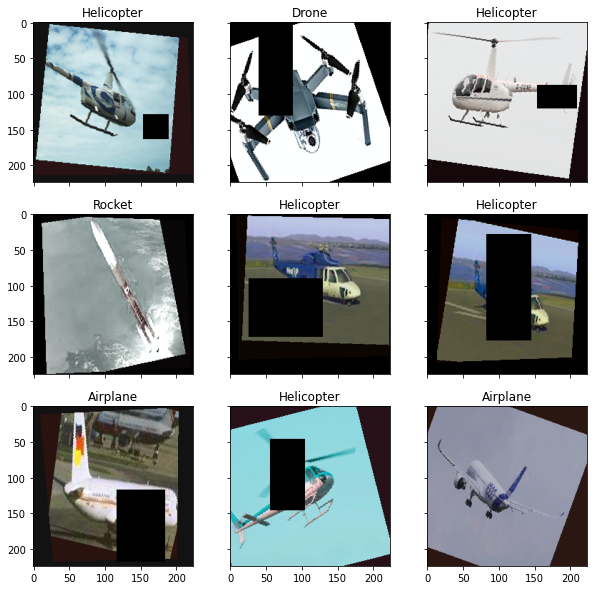

In [ ]:
# выведем некоторые изображения
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10), sharex=True, sharey=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,200))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Нейронная сеть: ResNet50

In [ ]:
from functools import partial

class Conv2d_Auto_Padding(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv_3x3 = partial(Conv2d_Auto_Padding, kernel_size=3, bias=False)

class Residual_Block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        self.in_channel=in_channel
        self.out_channel =  out_channel
        self.shortcut = nn.Identity() 
        self.blocks = nn.Identity()  
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut:
          residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x

    @property
    def should_apply_shortcut(self):
        return self.in_channel != self.out_channel

In [ ]:
from collections import OrderedDict

class ResNet_Residual_Block(Residual_Block):
    def __init__(self, in_channel, out_channel, downsampling=1, features_expansion=1, conv=conv_3x3, *args, **kwargs):
        super().__init__(in_channel, out_channel)
        self.downsampling= downsampling
        self.features_expansion= features_expansion
        self.conv = conv
        if self.should_apply_shortcut:
          self.shortcut = nn.Sequential(OrderedDict(
          {
              'conv' : nn.Conv2d(self.in_channel, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
              'bn' : nn.BatchNorm2d(self.expanded_channels)
          }))
        else:
          self.shortcut =None
        
        
    @property
    def expanded_channels(self):
        return self.out_channel * self.features_expansion

    @property
    def should_apply_shortcut(self):
        return self.in_channel != self.expanded_channels

def conv_BatchNorm2d(in_channel, out_channel, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channel, out_channel, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channel) }))

Блоки BottleNeck для ResNet:

<img src='https://drive.google.com/uc?export=view&id=1EfXfsElgIIdFcsTebxmKDCU5fa1M9ZW4' width="300">



Слой ResNet состоит из блоков, уложенных один за другим.

<img src='https://drive.google.com/uc?export=view&id=1z-clgvPybDdT64HMahsrGIJjlTIJaWn3' width="800">

Мы можем легко определить это, просто вставив n блоков один за другим.




In [ ]:
class ResNetBottleneck(ResNet_Residual_Block):
    features_expansion = 4
    def __init__(self, in_channel, out_channel, *args, **kwargs):
        super().__init__(in_channel, out_channel, features_expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_BatchNorm2d(self.in_channel, self.out_channel, self.conv, kernel_size=1),
             nn.ReLU(),
             conv_BatchNorm2d(self.out_channel, self.out_channel, self.conv, kernel_size=3, stride=self.downsampling),
             nn.ReLU(),
             conv_BatchNorm2d(self.out_channel, self.expanded_channels, self.conv, kernel_size=1),
        )

class ResNet_Layer(nn.Module):
    def __init__(self, in_channel, out_channel, nbr_block=1, *args, **kwargs):
        super().__init__()
        # Мы выполняем понижающую дискретизацию непосредственно сверточными слоями с шагом 2.'
        if in_channel != out_channel:
          downsampling = 2
        else:
          downsampling= 1
        # Заклеил nbr_block ResNetBottleneck блоков один за другим
        self.blocks = nn.Sequential(
            ResNetBottleneck(in_channel , out_channel, *args, **kwargs, downsampling=downsampling),
            *[ResNetBottleneck(out_channel * ResNetBottleneck.features_expansion, 
                    out_channel, downsampling=1, *args, **kwargs) for _ in range(nbr_block - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [ ]:
class ResNet_Encoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channel=3, distribution_nbr_block=[2,2,2,2], *args,**kwargs):
        super().__init__()
        
        distribution_nbr_channel = [64, 128, 256, 512]
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channel, distribution_nbr_channel[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(distribution_nbr_channel[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_channel = list(zip(distribution_nbr_channel, distribution_nbr_channel[1:]))
        self.blocks = nn.ModuleList([ 
            ResNet_Layer(distribution_nbr_channel[0], distribution_nbr_channel[0],
                         nbr_block=distribution_nbr_block[0], *args, **kwargs),
            *[ResNet_Layer(in_channel * ResNetBottleneck.features_expansion, 
                          out_channel, nbr_block=nbr_block, activation=nn.ReLU, 
                          block=ResNetBottleneck, *args, **kwargs)
              for (in_channel, out_channel), nbr_block in zip(self.in_out_channel, distribution_nbr_block[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [ ]:
class Resnet_Decoder(nn.Module):
    """
   Resnet Decoder выполняет average pooling, за которым следует полностью связанный слой для вывода класса.
    """
    def __init__(self, in_dimension, nbr_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_dimension, nbr_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

class ResNet(nn.Module):
    
    def __init__(self, in_channel, nbr_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNet_Encoder(in_channel, *args, **kwargs)
        self.decoder = Resnet_Decoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, nbr_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet50(in_channel, nbr_classes):
    return ResNet(in_channel, nbr_classes, distribution_nbr_block=[3, 4, 6, 3])

Функции для обучения и оценки модели. Тут можно поиграться с learning rate, добавить для него scheduler, который будет его варьировать.

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc
  
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs).to(DEVICE)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc
  
def train(train_files, val_files, model, epochs, batch_size,learning_rate,best_acc):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      
        #Здесь можно добавить схему изменения learning rate
        
        opt = torch.optim.Adam(model.parameters(),lr=learning_rate)

        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), '/content/drive/My Drive/summer-school-2020/Resnet50.pth')
                
    print('Best val Acc: {:4f}'.format(best_acc))
    
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Создадим модель, проверим, что в ней те слои, которые нам нужны.

In [ ]:
n_classes = len(np.unique(train_val_labels))
model = resnet50(3,n_classes).to(DEVICE)
best_acc=0
print(model)
batch_size=32

ResNet(
  (encoder): ResNet_Encoder(
    (gate): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNet_Layer(
        (blocks): Sequential(
          (0): ResNetBottleneck(
            (shortcut): Sequential(
              (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2d_Auto_Padding(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1):

# Тренировка

Запустим модель. Обрати внимание, что результат (и score) может немного отличаться в зависимости от batch_size.
Тут можно поменять на большее количество эпох. Но не переобучись!

In [ ]:
history = train(train_dataset, 
                val_dataset,
                model=model, 
                epochs=100,
                batch_size=batch_size,
                learning_rate=0.0001,
                best_acc=best_acc)

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

loss 1.527835003762018


epoch:   1%|          | 1/100 [01:34<2:35:46, 94.41s/it]


Epoch 001 train_loss: 1.5278     val_loss 1.2612 train_acc 0.3871 val_acc 0.4933
loss 1.657860671906244


epoch:   2%|▏         | 2/100 [03:08<2:34:12, 94.42s/it]


Epoch 002 train_loss: 1.6579     val_loss 1.2119 train_acc 0.3419 val_acc 0.4933
loss 1.3668549914587111


epoch:   3%|▎         | 3/100 [04:42<2:32:22, 94.25s/it]


Epoch 003 train_loss: 1.3669     val_loss 1.1720 train_acc 0.4443 val_acc 0.4678
loss 1.2671295679183234


epoch:   4%|▍         | 4/100 [06:16<2:30:35, 94.12s/it]


Epoch 004 train_loss: 1.2671     val_loss 1.1632 train_acc 0.4695 val_acc 0.4856
loss 1.1626936833063761


epoch:   5%|▌         | 5/100 [07:50<2:29:00, 94.11s/it]


Epoch 005 train_loss: 1.1627     val_loss 1.0179 train_acc 0.5190 val_acc 0.5878
loss 1.0082812637374514


epoch:   6%|▌         | 6/100 [09:25<2:27:36, 94.21s/it]


Epoch 006 train_loss: 1.0083     val_loss 0.7503 train_acc 0.5948 val_acc 0.7200
loss 0.9771220407031831


epoch:   7%|▋         | 7/100 [10:59<2:26:00, 94.20s/it]


Epoch 007 train_loss: 0.9771     val_loss 0.8125 train_acc 0.6176 val_acc 0.6811
loss 0.91409836042495


epoch:   8%|▊         | 8/100 [12:33<2:24:15, 94.08s/it]


Epoch 008 train_loss: 0.9141     val_loss 0.8923 train_acc 0.6362 val_acc 0.6433
loss 0.8772764076505388


epoch:   9%|▉         | 9/100 [14:06<2:22:32, 93.98s/it]


Epoch 009 train_loss: 0.8773     val_loss 0.7112 train_acc 0.6348 val_acc 0.7167
loss 0.9043394461132231


epoch:  10%|█         | 10/100 [15:40<2:20:57, 93.97s/it]


Epoch 010 train_loss: 0.9043     val_loss 0.6502 train_acc 0.6381 val_acc 0.7722
loss 0.7671271814618792


epoch:  11%|█         | 11/100 [17:14<2:19:30, 94.05s/it]


Epoch 011 train_loss: 0.7671     val_loss 0.6242 train_acc 0.7038 val_acc 0.7567
loss 0.7821642688342503


epoch:  12%|█▏        | 12/100 [18:49<2:18:00, 94.10s/it]


Epoch 012 train_loss: 0.7822     val_loss 0.6471 train_acc 0.6943 val_acc 0.7500
loss 0.7114366094271342


epoch:  13%|█▎        | 13/100 [20:22<2:16:15, 93.97s/it]


Epoch 013 train_loss: 0.7114     val_loss 0.6688 train_acc 0.7110 val_acc 0.7700
loss 0.7374648153214227


epoch:  14%|█▍        | 14/100 [21:56<2:14:33, 93.87s/it]


Epoch 014 train_loss: 0.7375     val_loss 0.5629 train_acc 0.7167 val_acc 0.7944
loss 0.7689242253984724


epoch:  15%|█▌        | 15/100 [23:30<2:13:14, 94.05s/it]


Epoch 015 train_loss: 0.7689     val_loss 0.5988 train_acc 0.6890 val_acc 0.7900
loss 0.6322668541613079


epoch:  16%|█▌        | 16/100 [25:04<2:11:36, 94.01s/it]


Epoch 016 train_loss: 0.6323     val_loss 0.6019 train_acc 0.7500 val_acc 0.7744
loss 0.6328945558411735


epoch:  17%|█▋        | 17/100 [26:38<2:09:48, 93.84s/it]


Epoch 017 train_loss: 0.6329     val_loss 0.7556 train_acc 0.7552 val_acc 0.7689
loss 0.638592096056257


epoch:  18%|█▊        | 18/100 [28:12<2:08:15, 93.85s/it]


Epoch 018 train_loss: 0.6386     val_loss 0.4883 train_acc 0.7624 val_acc 0.8178
loss 0.6251408077421643


epoch:  19%|█▉        | 19/100 [29:46<2:06:57, 94.04s/it]


Epoch 019 train_loss: 0.6251     val_loss 0.4543 train_acc 0.7610 val_acc 0.8333
loss 0.5985706701165154


epoch:  20%|██        | 20/100 [31:20<2:05:27, 94.09s/it]


Epoch 020 train_loss: 0.5986     val_loss 0.5200 train_acc 0.7805 val_acc 0.8189
loss 0.559486986767678


epoch:  21%|██        | 21/100 [32:54<2:03:49, 94.05s/it]


Epoch 021 train_loss: 0.5595     val_loss 0.4828 train_acc 0.7824 val_acc 0.8311
loss 0.5441424890926906


epoch:  22%|██▏       | 22/100 [34:29<2:02:23, 94.14s/it]


Epoch 022 train_loss: 0.5441     val_loss 0.4643 train_acc 0.7938 val_acc 0.8267
loss 0.5217855479603722


epoch:  23%|██▎       | 23/100 [36:02<2:00:38, 94.00s/it]


Epoch 023 train_loss: 0.5218     val_loss 0.5391 train_acc 0.8010 val_acc 0.8144
loss 0.5752595565432594


epoch:  24%|██▍       | 24/100 [37:36<1:59:01, 93.96s/it]


Epoch 024 train_loss: 0.5753     val_loss 0.4113 train_acc 0.7729 val_acc 0.8644
loss 0.5220344379970006


epoch:  25%|██▌       | 25/100 [39:11<1:57:44, 94.20s/it]


Epoch 025 train_loss: 0.5220     val_loss 0.4505 train_acc 0.7938 val_acc 0.8222
loss 0.4934800300711677


epoch:  26%|██▌       | 26/100 [40:45<1:56:05, 94.12s/it]


Epoch 026 train_loss: 0.4935     val_loss 0.3961 train_acc 0.8110 val_acc 0.8578
loss 0.4516935398465111


epoch:  27%|██▋       | 27/100 [42:19<1:54:22, 94.00s/it]


Epoch 027 train_loss: 0.4517     val_loss 0.4367 train_acc 0.8390 val_acc 0.8689
loss 0.43670512960070657


epoch:  28%|██▊       | 28/100 [43:53<1:53:04, 94.23s/it]


Epoch 028 train_loss: 0.4367     val_loss 0.5112 train_acc 0.8343 val_acc 0.8311
loss 0.44449944189616614


epoch:  29%|██▉       | 29/100 [45:28<1:51:31, 94.25s/it]


Epoch 029 train_loss: 0.4445     val_loss 0.4091 train_acc 0.8376 val_acc 0.8644
loss 0.5250146334511893


epoch:  30%|███       | 30/100 [47:02<1:49:59, 94.28s/it]


Epoch 030 train_loss: 0.5250     val_loss 0.3671 train_acc 0.8033 val_acc 0.8700
loss 0.4377537639935811


epoch:  31%|███       | 31/100 [48:37<1:48:33, 94.40s/it]


Epoch 031 train_loss: 0.4378     val_loss 0.4305 train_acc 0.8400 val_acc 0.8678
loss 0.43853614443824407


epoch:  32%|███▏      | 32/100 [50:11<1:46:57, 94.37s/it]


Epoch 032 train_loss: 0.4385     val_loss 0.3971 train_acc 0.8281 val_acc 0.8689
loss 0.4123325574965704


epoch:  33%|███▎      | 33/100 [51:45<1:45:18, 94.30s/it]


Epoch 033 train_loss: 0.4123     val_loss 0.3573 train_acc 0.8486 val_acc 0.8844
loss 0.35325841798668817


epoch:  34%|███▍      | 34/100 [53:19<1:43:43, 94.29s/it]


Epoch 034 train_loss: 0.3533     val_loss 0.3770 train_acc 0.8705 val_acc 0.8878
loss 0.3998818707466125


epoch:  35%|███▌      | 35/100 [54:54<1:42:18, 94.44s/it]


Epoch 035 train_loss: 0.3999     val_loss 0.3596 train_acc 0.8562 val_acc 0.8778
loss 0.3862079133306231


epoch:  36%|███▌      | 36/100 [56:28<1:40:36, 94.31s/it]


Epoch 036 train_loss: 0.3862     val_loss 0.4750 train_acc 0.8552 val_acc 0.8511
loss 0.4187906689870925


epoch:  37%|███▋      | 37/100 [58:02<1:38:58, 94.27s/it]


Epoch 037 train_loss: 0.4188     val_loss 0.4341 train_acc 0.8510 val_acc 0.8622
loss 0.3991759065219334


epoch:  38%|███▊      | 38/100 [59:37<1:37:28, 94.33s/it]


Epoch 038 train_loss: 0.3992     val_loss 0.3203 train_acc 0.8519 val_acc 0.8933
loss 0.374199358962831


epoch:  39%|███▉      | 39/100 [1:01:11<1:35:59, 94.42s/it]


Epoch 039 train_loss: 0.3742     val_loss 0.3448 train_acc 0.8695 val_acc 0.8844
loss 0.38208147423607963


epoch:  40%|████      | 40/100 [1:02:45<1:34:16, 94.27s/it]


Epoch 040 train_loss: 0.3821     val_loss 0.3733 train_acc 0.8581 val_acc 0.8933
loss 0.34175771594047544


epoch:  41%|████      | 41/100 [1:04:19<1:32:34, 94.15s/it]


Epoch 041 train_loss: 0.3418     val_loss 0.4748 train_acc 0.8795 val_acc 0.8611
loss 0.37461535930633544


epoch:  42%|████▏     | 42/100 [1:05:53<1:30:57, 94.09s/it]


Epoch 042 train_loss: 0.3746     val_loss 0.3824 train_acc 0.8686 val_acc 0.8878
loss 0.36103865345319114


epoch:  43%|████▎     | 43/100 [1:07:27<1:29:17, 93.99s/it]


Epoch 043 train_loss: 0.3610     val_loss 0.2976 train_acc 0.8557 val_acc 0.9156
loss 0.3096193066097441


epoch:  44%|████▍     | 44/100 [1:09:01<1:27:48, 94.08s/it]


Epoch 044 train_loss: 0.3096     val_loss 0.2952 train_acc 0.8833 val_acc 0.9122
loss 0.3329659959815797


epoch:  45%|████▌     | 45/100 [1:10:35<1:26:11, 94.03s/it]


Epoch 045 train_loss: 0.3330     val_loss 0.3246 train_acc 0.8724 val_acc 0.9033
loss 0.3518022269294375


epoch:  46%|████▌     | 46/100 [1:12:09<1:24:32, 93.93s/it]


Epoch 046 train_loss: 0.3518     val_loss 0.3302 train_acc 0.8686 val_acc 0.9033
loss 0.295852997303009


epoch:  47%|████▋     | 47/100 [1:13:43<1:22:59, 93.95s/it]


Epoch 047 train_loss: 0.2959     val_loss 0.3459 train_acc 0.8967 val_acc 0.9011
loss 0.33922549815404984


epoch:  48%|████▊     | 48/100 [1:15:17<1:21:27, 93.99s/it]


Epoch 048 train_loss: 0.3392     val_loss 0.3250 train_acc 0.8829 val_acc 0.8900
loss 0.2908322438739595


epoch:  49%|████▉     | 49/100 [1:16:51<1:19:49, 93.91s/it]


Epoch 049 train_loss: 0.2908     val_loss 0.3767 train_acc 0.8986 val_acc 0.8944
loss 0.3214000263668242


epoch:  50%|█████     | 50/100 [1:18:24<1:18:12, 93.85s/it]


Epoch 050 train_loss: 0.3214     val_loss 0.3487 train_acc 0.8800 val_acc 0.8944
loss 0.3200975133123852


epoch:  51%|█████     | 51/100 [1:19:59<1:16:45, 93.99s/it]


Epoch 051 train_loss: 0.3201     val_loss 0.3299 train_acc 0.8886 val_acc 0.8956
loss 0.3001450026886804


epoch:  52%|█████▏    | 52/100 [1:21:33<1:15:09, 93.95s/it]


Epoch 052 train_loss: 0.3001     val_loss 0.3559 train_acc 0.8790 val_acc 0.8900
loss 0.32742900110426404


epoch:  53%|█████▎    | 53/100 [1:23:06<1:13:33, 93.90s/it]


Epoch 053 train_loss: 0.3274     val_loss 0.3290 train_acc 0.8762 val_acc 0.8889
loss 0.30087877818516323


epoch:  54%|█████▍    | 54/100 [1:24:40<1:11:59, 93.90s/it]


Epoch 054 train_loss: 0.3009     val_loss 0.3657 train_acc 0.8943 val_acc 0.9078
loss 0.29531224341619583


epoch:  55%|█████▌    | 55/100 [1:26:14<1:10:24, 93.88s/it]


Epoch 055 train_loss: 0.2953     val_loss 0.2469 train_acc 0.8900 val_acc 0.9211
loss 0.23761311650276185


epoch:  56%|█████▌    | 56/100 [1:27:49<1:09:03, 94.16s/it]


Epoch 056 train_loss: 0.2376     val_loss 0.3261 train_acc 0.9057 val_acc 0.8856
loss 0.28679706210181827


epoch:  57%|█████▋    | 57/100 [1:29:23<1:07:32, 94.25s/it]


Epoch 057 train_loss: 0.2868     val_loss 0.3913 train_acc 0.8962 val_acc 0.8856
loss 0.2670490515232086


epoch:  58%|█████▊    | 58/100 [1:30:58<1:06:01, 94.32s/it]


Epoch 058 train_loss: 0.2670     val_loss 0.3434 train_acc 0.9076 val_acc 0.8844
loss 0.26213323033991315


epoch:  59%|█████▉    | 59/100 [1:32:32<1:04:28, 94.35s/it]


Epoch 059 train_loss: 0.2621     val_loss 0.2666 train_acc 0.9033 val_acc 0.9189
loss 0.2757110065647534


epoch:  60%|██████    | 60/100 [1:34:07<1:02:52, 94.32s/it]


Epoch 060 train_loss: 0.2757     val_loss 0.2758 train_acc 0.9005 val_acc 0.9256
loss 0.2624271198397591


epoch:  61%|██████    | 61/100 [1:35:42<1:01:26, 94.53s/it]


Epoch 061 train_loss: 0.2624     val_loss 0.2542 train_acc 0.9033 val_acc 0.9233
loss 0.23252504729089282


epoch:  62%|██████▏   | 62/100 [1:37:16<59:49, 94.46s/it]


Epoch 062 train_loss: 0.2325     val_loss 0.3730 train_acc 0.9129 val_acc 0.8989
loss 0.2688435935406458


epoch:  63%|██████▎   | 63/100 [1:38:51<58:17, 94.52s/it]


Epoch 063 train_loss: 0.2688     val_loss 0.3082 train_acc 0.9086 val_acc 0.9078
loss 0.2392802929878235


epoch:  64%|██████▍   | 64/100 [1:40:25<56:42, 94.51s/it]


Epoch 064 train_loss: 0.2393     val_loss 0.2256 train_acc 0.9071 val_acc 0.9356
loss 0.22124466331232162


epoch:  65%|██████▌   | 65/100 [1:42:01<55:19, 94.83s/it]


Epoch 065 train_loss: 0.2212     val_loss 0.2785 train_acc 0.9143 val_acc 0.9133
loss 0.21995389142206737


epoch:  66%|██████▌   | 66/100 [1:43:35<53:44, 94.85s/it]


Epoch 066 train_loss: 0.2200     val_loss 0.2922 train_acc 0.9210 val_acc 0.9233
loss 0.24902217166764395


epoch:  67%|██████▋   | 67/100 [1:45:10<52:10, 94.87s/it]


Epoch 067 train_loss: 0.2490     val_loss 0.2580 train_acc 0.9076 val_acc 0.9211
loss 0.19099542211918605


epoch:  68%|██████▊   | 68/100 [1:46:45<50:34, 94.84s/it]


Epoch 068 train_loss: 0.1910     val_loss 0.2555 train_acc 0.9324 val_acc 0.9289
loss 0.25754809826612474


epoch:  69%|██████▉   | 69/100 [1:48:20<49:01, 94.89s/it]


Epoch 069 train_loss: 0.2575     val_loss 0.2413 train_acc 0.9019 val_acc 0.9344
loss 0.23754776318868


epoch:  70%|███████   | 70/100 [1:49:55<47:25, 94.84s/it]


Epoch 070 train_loss: 0.2375     val_loss 0.2287 train_acc 0.9171 val_acc 0.9256
loss 0.2254246376525788


epoch:  71%|███████   | 71/100 [1:51:30<45:52, 94.91s/it]


Epoch 071 train_loss: 0.2254     val_loss 0.4049 train_acc 0.9271 val_acc 0.8978
loss 0.23740469898496355


epoch:  72%|███████▏  | 72/100 [1:53:05<44:17, 94.92s/it]


Epoch 072 train_loss: 0.2374     val_loss 0.4940 train_acc 0.9052 val_acc 0.8644
loss 0.22418794617766424


epoch:  73%|███████▎  | 73/100 [1:54:40<42:43, 94.93s/it]


Epoch 073 train_loss: 0.2242     val_loss 0.2733 train_acc 0.9110 val_acc 0.9244
loss 0.22291251852398827


epoch:  74%|███████▍  | 74/100 [1:56:15<41:09, 94.98s/it]


Epoch 074 train_loss: 0.2229     val_loss 0.3360 train_acc 0.9143 val_acc 0.9056
loss 0.22207701668852853


epoch:  75%|███████▌  | 75/100 [1:57:50<39:34, 95.00s/it]


Epoch 075 train_loss: 0.2221     val_loss 0.3203 train_acc 0.9214 val_acc 0.9022
loss 0.1929815623022261


epoch:  76%|███████▌  | 76/100 [1:59:25<38:02, 95.08s/it]


Epoch 076 train_loss: 0.1930     val_loss 0.3201 train_acc 0.9343 val_acc 0.9222
loss 0.206328759104723


epoch:  77%|███████▋  | 77/100 [2:01:00<36:27, 95.10s/it]


Epoch 077 train_loss: 0.2063     val_loss 0.3044 train_acc 0.9305 val_acc 0.9267
loss 0.19031743498785156


epoch:  78%|███████▊  | 78/100 [2:02:36<34:53, 95.14s/it]


Epoch 078 train_loss: 0.1903     val_loss 0.2713 train_acc 0.9329 val_acc 0.9233
loss 0.16206075520742508


epoch:  79%|███████▉  | 79/100 [2:04:11<33:18, 95.14s/it]


Epoch 079 train_loss: 0.1621     val_loss 0.3469 train_acc 0.9471 val_acc 0.9344
loss 0.26379546040580387


epoch:  80%|████████  | 80/100 [2:05:46<31:44, 95.25s/it]


Epoch 080 train_loss: 0.2638     val_loss 0.3435 train_acc 0.9090 val_acc 0.8911
loss 0.2492371938235703


epoch:  81%|████████  | 81/100 [2:07:22<30:11, 95.34s/it]


Epoch 081 train_loss: 0.2492     val_loss 0.2325 train_acc 0.9152 val_acc 0.9378
loss 0.18772869947410764


epoch:  82%|████████▏ | 82/100 [2:08:57<28:37, 95.42s/it]


Epoch 082 train_loss: 0.1877     val_loss 0.7559 train_acc 0.9290 val_acc 0.8089
loss 0.22815286250341507


epoch:  83%|████████▎ | 83/100 [2:10:33<27:01, 95.41s/it]


Epoch 083 train_loss: 0.2282     val_loss 0.2589 train_acc 0.9224 val_acc 0.9244
loss 0.1839564578589939


epoch:  84%|████████▍ | 84/100 [2:12:08<25:26, 95.38s/it]


Epoch 084 train_loss: 0.1840     val_loss 0.2394 train_acc 0.9314 val_acc 0.9300
loss 0.17753577760287695


epoch:  85%|████████▌ | 85/100 [2:13:43<23:49, 95.30s/it]


Epoch 085 train_loss: 0.1775     val_loss 0.2147 train_acc 0.9357 val_acc 0.9411
loss 0.15656897254642987


epoch:  86%|████████▌ | 86/100 [2:15:19<22:14, 95.31s/it]


Epoch 086 train_loss: 0.1566     val_loss 0.2671 train_acc 0.9429 val_acc 0.9211
loss 0.1796400761746225


epoch:  87%|████████▋ | 87/100 [2:16:54<20:39, 95.31s/it]


Epoch 087 train_loss: 0.1796     val_loss 0.2560 train_acc 0.9343 val_acc 0.9322
loss 0.17872263855877377


epoch:  88%|████████▊ | 88/100 [2:18:29<19:03, 95.31s/it]


Epoch 088 train_loss: 0.1787     val_loss 0.2501 train_acc 0.9329 val_acc 0.9411
loss 0.1883431954327084


epoch:  89%|████████▉ | 89/100 [2:20:05<17:28, 95.36s/it]


Epoch 089 train_loss: 0.1883     val_loss 0.2260 train_acc 0.9300 val_acc 0.9256
loss 0.1479315084077063


epoch:  90%|█████████ | 90/100 [2:21:40<15:52, 95.29s/it]


Epoch 090 train_loss: 0.1479     val_loss 0.2480 train_acc 0.9495 val_acc 0.9389
loss 0.17764723129215695


epoch:  91%|█████████ | 91/100 [2:23:15<14:18, 95.34s/it]


Epoch 091 train_loss: 0.1776     val_loss 0.3211 train_acc 0.9410 val_acc 0.9167
loss 0.1702759094181515


epoch:  92%|█████████▏| 92/100 [2:24:51<12:43, 95.43s/it]


Epoch 092 train_loss: 0.1703     val_loss 0.3080 train_acc 0.9410 val_acc 0.9189
loss 0.2022262959466094


epoch:  93%|█████████▎| 93/100 [2:26:26<11:08, 95.45s/it]


Epoch 093 train_loss: 0.2022     val_loss 0.2385 train_acc 0.9267 val_acc 0.9467
loss 0.1723413100980577


epoch:  94%|█████████▍| 94/100 [2:28:03<09:33, 95.65s/it]


Epoch 094 train_loss: 0.1723     val_loss 0.2163 train_acc 0.9352 val_acc 0.9367
loss 0.18116005264577412


epoch:  95%|█████████▌| 95/100 [2:29:37<07:56, 95.30s/it]


Epoch 095 train_loss: 0.1812     val_loss 0.3700 train_acc 0.9319 val_acc 0.9067
loss 0.16809933300529206


epoch:  96%|█████████▌| 96/100 [2:31:11<06:20, 95.03s/it]


Epoch 096 train_loss: 0.1681     val_loss 0.3172 train_acc 0.9410 val_acc 0.9200
loss 0.1808251178122702


epoch:  97%|█████████▋| 97/100 [2:32:46<04:44, 94.94s/it]


Epoch 097 train_loss: 0.1808     val_loss 0.2036 train_acc 0.9362 val_acc 0.9411
loss 0.13939131662959145


epoch:  98%|█████████▊| 98/100 [2:34:21<03:09, 94.83s/it]


Epoch 098 train_loss: 0.1394     val_loss 0.2847 train_acc 0.9476 val_acc 0.9344
loss 0.14644668284626233


epoch:  99%|█████████▉| 99/100 [2:35:55<01:34, 94.60s/it]


Epoch 099 train_loss: 0.1464     val_loss 0.2640 train_acc 0.9433 val_acc 0.9300
loss 0.1982514499837444


epoch: 100%|██████████| 100/100 [2:37:29<00:00, 94.50s/it]


Epoch 100 train_loss: 0.1983     val_loss 0.2881 train_acc 0.9324 val_acc 0.9256
Best val Acc: 0.946667


Загрузка лучшей сохраненной модели.

In [ ]:
model = resnet50(3,n_classes).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/My Drive/summer-school-2020/Resnet50.pth'))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
best_acc=eval_epoch(model, val_loader, criterion)[1].item()
print('val Acc: ' + str(best_acc))

val Acc: 0.9466666666666667


Скорость обучения снижена.

In [ ]:
history = train(train_dataset, 
                val_dataset,
                model=model, 
                epochs=50,
                batch_size=batch_size,
                learning_rate=0.00001,
                best_acc=best_acc)

epoch:   0%|          | 0/40 [00:00<?, ?it/s]

loss 0.10297851906291076


epoch:   2%|▎         | 1/40 [01:39<1:04:23, 99.06s/it]


Epoch 001 train_loss: 0.1030     val_loss 0.2584 train_acc 0.9643 val_acc 0.9389
loss 0.07614395586152871


epoch:   5%|▌         | 2/40 [03:18<1:02:52, 99.28s/it]


Epoch 002 train_loss: 0.0761     val_loss 0.2612 train_acc 0.9719 val_acc 0.9411
loss 0.07614643260237894


epoch:   8%|▊         | 3/40 [04:59<1:01:27, 99.67s/it]


Epoch 003 train_loss: 0.0761     val_loss 0.2481 train_acc 0.9724 val_acc 0.9400
loss 0.06138627686316059


epoch:  10%|█         | 4/40 [06:40<59:58, 99.96s/it]


Epoch 004 train_loss: 0.0614     val_loss 0.2554 train_acc 0.9738 val_acc 0.9422
loss 0.06928460222624597


epoch:  12%|█▎        | 5/40 [08:20<58:26, 100.18s/it]


Epoch 005 train_loss: 0.0693     val_loss 0.2393 train_acc 0.9757 val_acc 0.9444
loss 0.06929918771698361


epoch:  15%|█▌        | 6/40 [10:01<56:52, 100.38s/it]


Epoch 006 train_loss: 0.0693     val_loss 0.2431 train_acc 0.9762 val_acc 0.9422
loss 0.06569788832572244


epoch:  18%|█▊        | 7/40 [11:42<55:13, 100.41s/it]


Epoch 007 train_loss: 0.0657     val_loss 0.2408 train_acc 0.9800 val_acc 0.9489
loss 0.06093831199975241


epoch:  20%|██        | 8/40 [13:23<53:46, 100.83s/it]


Epoch 008 train_loss: 0.0609     val_loss 0.2314 train_acc 0.9776 val_acc 0.9478
loss 0.05209367244105254


epoch:  22%|██▎       | 9/40 [15:05<52:08, 100.92s/it]


Epoch 009 train_loss: 0.0521     val_loss 0.2299 train_acc 0.9838 val_acc 0.9456
loss 0.05193033328634642


epoch:  25%|██▌       | 10/40 [16:45<50:26, 100.88s/it]


Epoch 010 train_loss: 0.0519     val_loss 0.2328 train_acc 0.9800 val_acc 0.9433
loss 0.045112560728476164


epoch:  28%|██▊       | 11/40 [18:26<48:46, 100.91s/it]


Epoch 011 train_loss: 0.0451     val_loss 0.2427 train_acc 0.9824 val_acc 0.9456
loss 0.05777723130903074


epoch:  30%|███       | 12/40 [20:07<47:05, 100.93s/it]


Epoch 012 train_loss: 0.0578     val_loss 0.2410 train_acc 0.9771 val_acc 0.9456
loss 0.05934156537499456


epoch:  32%|███▎      | 13/40 [21:48<45:26, 100.97s/it]


Epoch 013 train_loss: 0.0593     val_loss 0.2321 train_acc 0.9800 val_acc 0.9411
loss 0.050410910678495256


epoch:  35%|███▌      | 14/40 [23:29<43:43, 100.89s/it]


Epoch 014 train_loss: 0.0504     val_loss 0.2301 train_acc 0.9829 val_acc 0.9478
loss 0.0625808966009035


epoch:  38%|███▊      | 15/40 [25:09<41:51, 100.48s/it]


Epoch 015 train_loss: 0.0626     val_loss 0.2293 train_acc 0.9762 val_acc 0.9456
loss 0.054821176782605195


epoch:  40%|████      | 16/40 [26:49<40:13, 100.55s/it]


Epoch 016 train_loss: 0.0548     val_loss 0.2382 train_acc 0.9800 val_acc 0.9433
loss 0.05390871565700287


epoch:  42%|████▎     | 17/40 [28:30<38:32, 100.53s/it]


Epoch 017 train_loss: 0.0539     val_loss 0.2496 train_acc 0.9833 val_acc 0.9422
loss 0.0403435659284393


epoch:  45%|████▌     | 18/40 [30:10<36:52, 100.55s/it]


Epoch 018 train_loss: 0.0403     val_loss 0.2471 train_acc 0.9852 val_acc 0.9444
loss 0.0521476229870071


epoch:  48%|████▊     | 19/40 [31:51<35:12, 100.61s/it]


Epoch 019 train_loss: 0.0521     val_loss 0.2443 train_acc 0.9819 val_acc 0.9422
loss 0.04898129117231639


epoch:  50%|█████     | 20/40 [33:32<33:34, 100.73s/it]


Epoch 020 train_loss: 0.0490     val_loss 0.2627 train_acc 0.9824 val_acc 0.9456
loss 0.04437931282445788


epoch:  52%|█████▎    | 21/40 [35:13<31:55, 100.80s/it]


Epoch 021 train_loss: 0.0444     val_loss 0.2384 train_acc 0.9810 val_acc 0.9456
loss 0.04978690292553178


epoch:  55%|█████▌    | 22/40 [36:53<30:11, 100.65s/it]


Epoch 022 train_loss: 0.0498     val_loss 0.2450 train_acc 0.9833 val_acc 0.9522
loss 0.0474093469615937


epoch:  57%|█████▊    | 23/40 [38:34<28:31, 100.68s/it]


Epoch 023 train_loss: 0.0474     val_loss 0.2186 train_acc 0.9852 val_acc 0.9489
loss 0.04462229747513664


epoch:  60%|██████    | 24/40 [40:15<26:51, 100.72s/it]


Epoch 024 train_loss: 0.0446     val_loss 0.2268 train_acc 0.9862 val_acc 0.9467
loss 0.03625611981232872


epoch:  62%|██████▎   | 25/40 [41:56<25:10, 100.68s/it]


Epoch 025 train_loss: 0.0363     val_loss 0.2285 train_acc 0.9876 val_acc 0.9500
loss 0.04015830213558816


epoch:  65%|██████▌   | 26/40 [43:36<23:29, 100.68s/it]


Epoch 026 train_loss: 0.0402     val_loss 0.2338 train_acc 0.9862 val_acc 0.9500
loss 0.03901461691972578


epoch:  68%|██████▊   | 27/40 [45:17<21:48, 100.64s/it]


Epoch 027 train_loss: 0.0390     val_loss 0.2379 train_acc 0.9852 val_acc 0.9422
loss 0.04502581816698824


epoch:  70%|███████   | 28/40 [46:58<20:10, 100.91s/it]


Epoch 028 train_loss: 0.0450     val_loss 0.2302 train_acc 0.9857 val_acc 0.9533
loss 0.05328819577537832


epoch:  72%|███████▎  | 29/40 [48:40<18:32, 101.18s/it]


Epoch 029 train_loss: 0.0533     val_loss 0.2250 train_acc 0.9819 val_acc 0.9500
loss 0.039584067702914276


epoch:  75%|███████▌  | 30/40 [50:21<16:51, 101.15s/it]


Epoch 030 train_loss: 0.0396     val_loss 0.2532 train_acc 0.9867 val_acc 0.9400
loss 0.04470984384240139


epoch:  78%|███████▊  | 31/40 [52:02<15:09, 101.04s/it]


Epoch 031 train_loss: 0.0447     val_loss 0.2387 train_acc 0.9862 val_acc 0.9456
loss 0.05270277219026216


epoch:  80%|████████  | 32/40 [53:43<13:28, 101.08s/it]


Epoch 032 train_loss: 0.0527     val_loss 0.2351 train_acc 0.9824 val_acc 0.9467
loss 0.03911541476734869


epoch:  82%|████████▎ | 33/40 [55:24<11:47, 101.13s/it]


Epoch 033 train_loss: 0.0391     val_loss 0.2314 train_acc 0.9833 val_acc 0.9500
loss 0.041885979355574816


epoch:  85%|████████▌ | 34/40 [57:06<10:07, 101.31s/it]


Epoch 034 train_loss: 0.0419     val_loss 0.2376 train_acc 0.9852 val_acc 0.9533
loss 0.04433517377380104


epoch:  88%|████████▊ | 35/40 [58:48<08:27, 101.46s/it]


Epoch 035 train_loss: 0.0443     val_loss 0.2241 train_acc 0.9848 val_acc 0.9522
loss 0.041543911255097814


epoch:  90%|█████████ | 36/40 [1:00:29<06:45, 101.39s/it]


Epoch 036 train_loss: 0.0415     val_loss 0.2201 train_acc 0.9833 val_acc 0.9533
loss 0.04701896480062888


epoch:  92%|█████████▎| 37/40 [1:02:10<05:04, 101.36s/it]


Epoch 037 train_loss: 0.0470     val_loss 0.2417 train_acc 0.9857 val_acc 0.9511
loss 0.032456033346908435


epoch:  95%|█████████▌| 38/40 [1:03:52<03:22, 101.35s/it]


Epoch 038 train_loss: 0.0325     val_loss 0.2353 train_acc 0.9881 val_acc 0.9522
loss 0.04900400028963174


epoch:  98%|█████████▊| 39/40 [1:05:33<01:41, 101.24s/it]


Epoch 039 train_loss: 0.0490     val_loss 0.2587 train_acc 0.9829 val_acc 0.9478
loss 0.04375703102731634


epoch: 100%|██████████| 40/40 [1:07:14<00:00, 100.86s/it]


Epoch 040 train_loss: 0.0438     val_loss 0.2306 train_acc 0.9857 val_acc 0.9522
Best val Acc: 0.953333


In [ ]:
model = resnet50(3,n_classes).to(DEVICE)
model.load_state_dict(torch.load('/content/drive/My Drive/summer-school-2020/Resnet50.pth'))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
best_acc=eval_epoch(model, val_loader, criterion)[1].item()
print('val Acc: ' + str(best_acc))

val Acc: 0.9544444444444444


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

# Изучаем результат тренировки

Сеточку обучили. Вывели результаты тренировкис помощью графиков. Хорошо бы понять, как сделать сабмит. У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей того, что объект относится к тому или иному классу. Давайте воспользуемся этим.


In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,200))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,200, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
actual_labels = [label_encoder.classes_[i] for i in actual_labels]
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
actual_labels

['airplane',
 'helicopter',
 'rocket',
 'rocket',
 'jet',
 'jet',
 'drone',
 'helicopter',
 'drone',
 'drone',
 'rocket',
 'rocket',
 'jet',
 'jet',
 'rocket',
 'drone',
 'rocket',
 'jet',
 'airplane',
 'drone']

In [ ]:
preds_class

['airplane',
 'helicopter',
 'rocket',
 'rocket',
 'jet',
 'jet',
 'drone',
 'helicopter',
 'drone',
 'drone',
 'rocket',
 'rocket',
 'jet',
 'jet',
 'rocket',
 'drone',
 'rocket',
 'jet',
 'airplane',
 'drone']

Сделаем классную визуализацию, чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

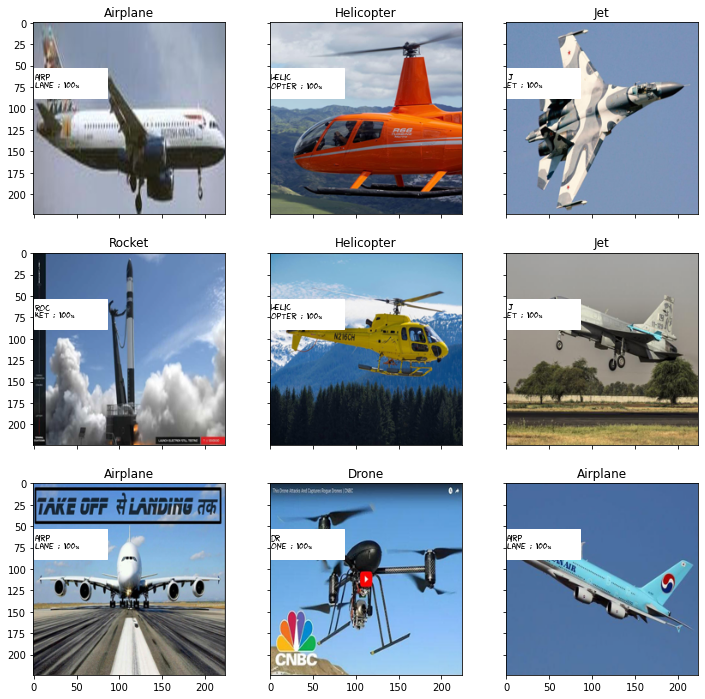

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,200))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Submission

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = PlanesDataset(test_files, mode="test", augmentations=False)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name.split('.')[0] for path in test_dataset.files]

In [ ]:
submit = pd.DataFrame({'id_image': test_filenames, 'label': preds})
submit.head()

,id_image,label
0,ABlOlXVIuGIDCpoT,rocket
1,AErddJMswOyhbBWO,helicopter
2,AJpjISmpEQVIJeNw,rocket
3,ANNgPwweGzZpyMLC,drone
4,ASyVcErZvWjBztpE,drone


In [ ]:
submit.to_csv('submission.csv', index=False)

В итоге мы обучили сетку и создали файл с предсказанными классами для тестовых данных. Далее жмякаем на "Save version", выбираем, чтоб сохранилось с аутпутом, и сохрвняем нашу версию ноутбука с полученными результатами. 

![image.png](attachment:image.png)

После того, как сохранение завершится, переходим во Вьювер, скролим сниз до Output. Кликаем на созданный нами файл submission.csv и саблитим ответ (кнопка Сабмит).

![image.png](attachment:image.png)

Появится результат точности вашей модельки. Радуемся сеточной и работаем над ее улучшением)

Возможные методы оптимизации:
> 
- Схема текущей модели (помимо того, что уже использовали при построении слоев, почитай еще про:)
- - **батч-нормализацию** 
- - предотвращает искажение данных тем, что нормализует входные данные так, чтобы получить матожидание=0 и дисперсию=1 (в путорче BatchNorm2d/BatchNorm1d) 
- - **дропаут** 
- -  предотвращает переобучение тем,что отключает некоторое количество нейронов на разных итерациях во время обучениия (в путорче Dropout)
* Добавляем аугментаций
* Обязательно играем с параметрами
* Оптимизируем learning rate, batch size и вот это всё


Albumentations

https://github.com/albumentations-team/albumentations#how-to-use

![image.png](attachment:image.png)